## Figure 4: Feature importance

This notebook reproduces Figure 4. It also includes boxplots showing the distributions of the most importance features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import load

from lib.format_feature_names import format_feature_name
from lib.pu import (
    COLUMNS_TO_DROP,
    CORRELATED_COLUMNS,
    PRESERVATION_COLUMNS,
)

### Load PU classifier and training data

In [2]:
classifier_filename = "outputs/pu_classifier.joblib"
training_filename = "training_data.csv"

classifier = load(classifier_filename)
df_training = pd.read_csv(training_filename)

### Calculate feature importance

In [3]:
importance_array = np.array(
    [
        i.feature_importances_
        for i in classifier.estimators_
    ]
).mean(axis=0)

to_drop = COLUMNS_TO_DROP | CORRELATED_COLUMNS | PRESERVATION_COLUMNS
to_drop.add("label")

feature_names = sorted(set(df_training.columns).difference(to_drop))
feature_names = np.array(feature_names, dtype="object")

importances = pd.Series(importance_array, index=feature_names)

pd.DataFrame(
    {
        "importance (absolute)": importances,
        "importance (relative)": importances / importances.max(),
    }
).sort_values(by="importance (relative)", ascending=False)

,importance (absolute),importance (relative)
crustal_thickness_mean (m),0.184651,1.000000
distance_to_trench (km),0.068586,0.371436
convergence_rate_orthogonal (cm/yr),0.066842,0.361992
trench_velocity_orthogonal (cm/yr),0.058447,0.316525
seafloor_spreading_rate (km/Myr),0.054059,0.292764
subducted_carbonates_volume (m),0.042524,0.230295
seafloor_age (Ma),0.035445,0.191958
subducting_plate_absolute_velocity_orthogonal (cm/yr),0.033599,0.181960
trench_velocity_obliquity (degrees),0.032520,0.176113
subducted_sediment_volume (m),0.031217,0.169058


### Plot feature importances (bar chart)

In [4]:
normalise = True  # show relative importance values
num_to_keep = 6  # show 6 most important features

importances_sorted = importances.sort_values(ascending=False)
if normalise:
    importances_sorted /= np.nanmax(importances)

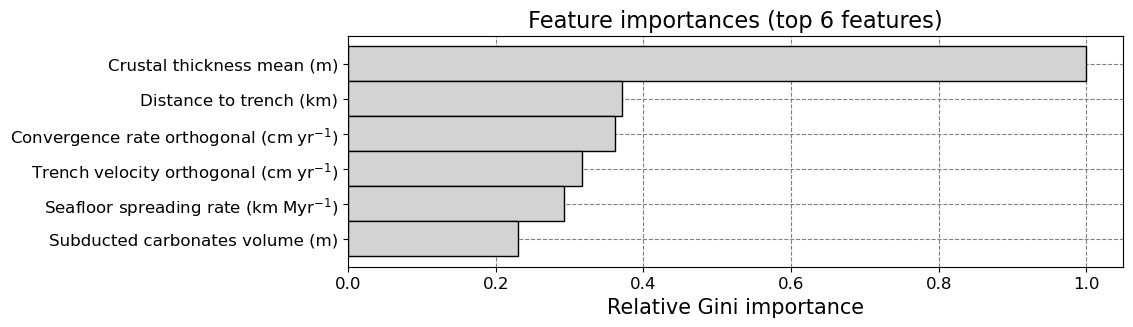

In [5]:
colour = False
facecolor = "cyan" if colour else "lightgrey"
edgecolor = "blue" if colour else "black"

font_size = num_to_keep * 2
xlabel_size = font_size * 1.25
title_size = font_size * 1.35
ylocs = -1 * np.arange(num_to_keep)

fig, ax = plt.subplots(
    figsize=(10, num_to_keep * 0.5)
)
ax.barh(
    y=ylocs,
    width=importances_sorted.iloc[:num_to_keep],
    height=1.0,
    facecolor=facecolor,
    edgecolor=edgecolor,
    zorder=1
)
ax.yaxis.set_ticks(ylocs)
ax.yaxis.set_ticklabels(
    [
        format_feature_name(i)
        for i in
        importances_sorted.iloc[:num_to_keep].index
    ]
)
ax.tick_params(labelsize=font_size)
ax.grid(linestyle="dashed", color="grey")
ax.set_axisbelow(True)

xlabel = "Gini importance"
if normalise:
    xlabel = "Relative " + xlabel
ax.set_xlabel(xlabel, fontsize=xlabel_size)
title = "Feature importances"
if num_to_keep is not None:
    title += " (top {} features)".format(num_to_keep)
ax.set_title(title, fontsize=title_size)

for extension in (".png", ".pdf"):
    fig.savefig(
        "outputs/figures/feature_importances" + extension,
        dpi=350,
        bbox_inches="tight",
    )

### Plot important feature distributions (box plots)

In [6]:
df_boxplots = df_training.copy()
positive_boxplots = df_boxplots[
    (df_boxplots["source"] == "Diaz-Rodriguez et al. 2021")
    & (df_boxplots["label"] == "positive")
]
random_boxplots = df_boxplots[
    (df_boxplots["source"] == "random")
    & (df_boxplots["label"].isin(("unlabelled", "unlabeled")))
]

print("Mean values:")
for column in importances_sorted.iloc[:num_to_keep].index:
    a = np.around(positive_boxplots[column].mean(), 2)
    b = np.around(random_boxplots[column].mean(), 2)
    print("{} - positive = {}, random = {}".format(column, a, b))

Mean values:
crustal_thickness_mean (m) - positive = 46594.02, random = 35969.5
distance_to_trench (km) - positive = 415.95, random = 270.8
convergence_rate_orthogonal (cm/yr) - positive = 9.02, random = 4.87
trench_velocity_orthogonal (cm/yr) - positive = -2.2, random = -0.87
seafloor_spreading_rate (km/Myr) - positive = 118.21, random = 84.39
subducted_carbonates_volume (m) - positive = 339.85, random = 158.01


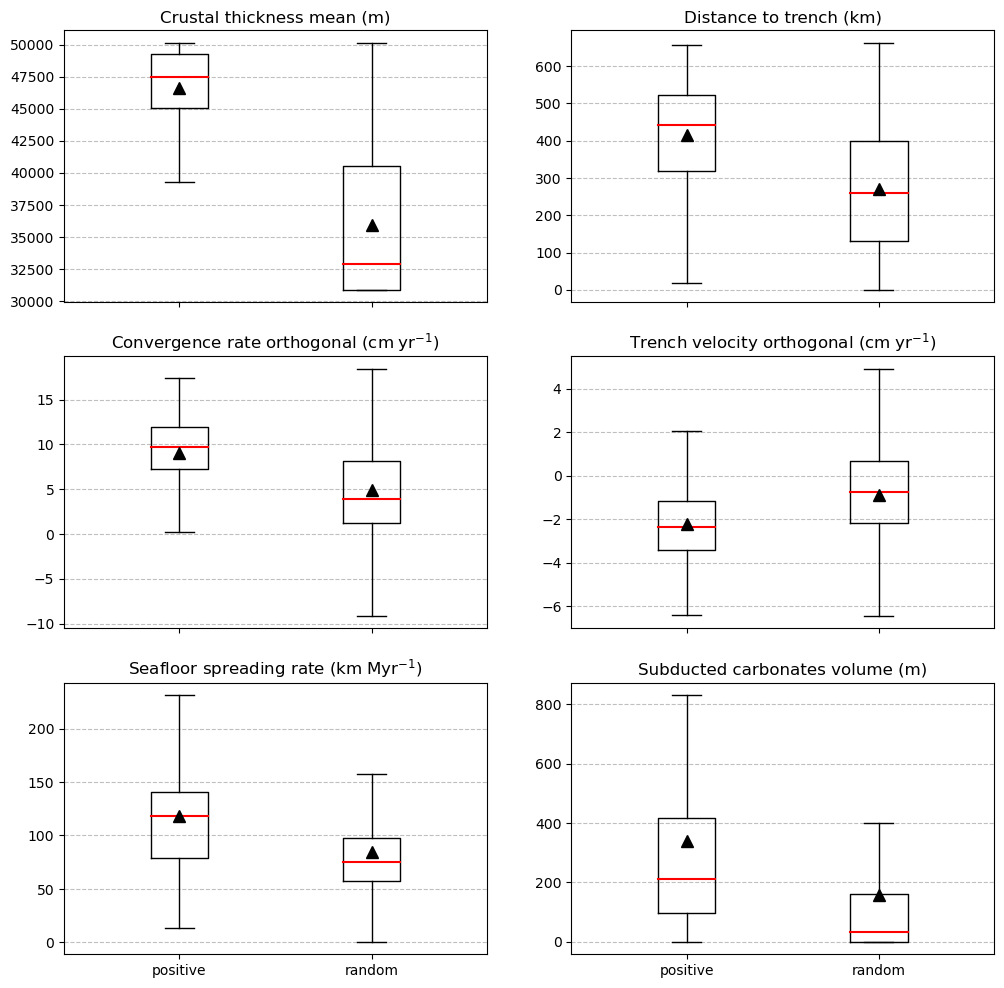

In [7]:
marker_colour = "grey"
positions = np.array((0, 0.5))
xlims = positions + np.array((-0.3, 0.3))

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for i, (column, ax) in enumerate(
    zip(
        importances_sorted.iloc[:num_to_keep].index,
        np.ravel(axs),
    )
):
    a = positive_boxplots[column].dropna()
    b = random_boxplots[column].dropna()
    if i >= num_to_keep - 2:
        labels = ("positive", "random")
    else:
        labels = ("", "")
    ax.boxplot(
        (a, b),
        positions=positions,
        flierprops=dict(
            marker="o",
            markerfacecolor=marker_colour,
            markeredgecolor=marker_colour,
            markersize=3,
        ),
        meanprops=dict(
            marker="^",
            markerfacecolor="black",
            markeredgecolor="black",
            markersize=8,
        ),
        medianprops=dict(
            color="red",
            linewidth=1.5,
        ),
        showfliers=False,
        showmeans=True,
        labels=labels,
    )
    ax.set_title(format_feature_name(column))
    ax.set_xticks(positions)
    ax.set_xlim(*xlims)
    ax.grid(linestyle="dashed", color="grey", alpha=0.5, axis="y")

for ext in (".png", ".pdf"):
    fig.savefig(
        "outputs/figures/feature_boxplots" + ext,
        dpi=350,
        bbox_inches="tight",
    )